# Guassian mixture clustering

Generate a few clusters

(1500, 2)


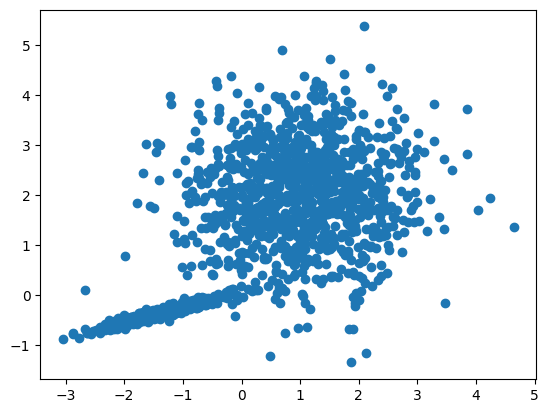

In [112]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import numpy as np
import matplotlib.pyplot as plt

x1 = np.random.normal(loc=1.0, scale=1.0, size=1000)
y1 = np.random.normal(loc=2.0, scale=1.0, size=1000)

x2 = np.random.normal(loc=-1.0, scale=0.5, size=500)
y2 = np.random.normal(loc=-1.0, scale=0.5, size=500)

a = np.array([[3,1],[1,0]])/3
v = np.concatenate([x2[:, None], y2[:, None]], axis=1) @ a
x2, y2 = v[:,0], v[:,1]


u, s, vh = np.linalg.svd(a)

x = np.concatenate([x1, x2])
y = np.concatenate([y1, y2])

plt.scatter(x, y)

data = np.stack([x, y], axis=1)
print(data.shape)


Do fitting

[[-1.34830127 -0.33946672]
 [ 1.00755302  1.95790975]] [[[2.55092806e-01 7.74133536e-02]
  [7.74133536e-02 2.62194723e-02]]

 [[9.92707857e-01 3.40353325e-04]
  [3.40353325e-04 9.91445327e-01]]]


[[0.22374002 1.24148345]] [[[1.96858165 1.26982423]
  [1.26982423 1.9055103 ]]]
Num covered: 0.9886666666666667, valid covered: 0.9886666666666667, overlapped: 0.0


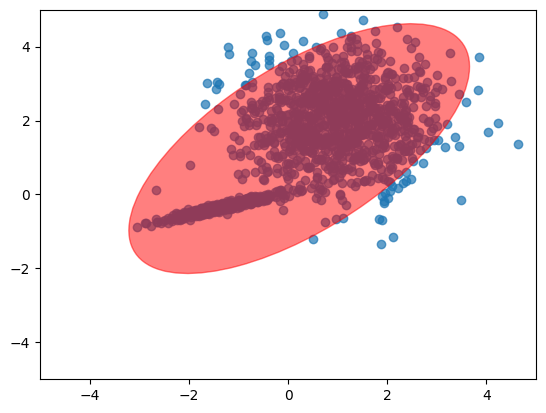

In [202]:
from matplotlib.patches import Ellipse
import scipy, math



def get_ellipse_patch(center, cov, confidence=0.95):
    # Figure out number of stdevs for confidence
    scale = math.sqrt(scipy.stats.chi2.ppf(q=confidence, df=center.shape[0]))
    
    u, s, vh = np.linalg.svd(cov)
    if np.linalg.det(u) > 0:
        return Ellipse((center[0], center[1]), np.sqrt(s[0]) * scale * 2, np.sqrt(s[1])* scale * 2, angle=np.arccos(np.dot(np.array([1, 0]), u[:,0])) * 180 / np.pi, alpha=0.5, color='red')
    else:
        return Ellipse((center[0], center[1]), np.sqrt(s[1])* scale * 2, np.sqrt(s[0])* scale * 2, angle=np.arccos(np.dot(np.array([1, 0]), u[:,1])) * 180 / np.pi, alpha=0.5, color='red')


# Returns an list of patches, a Numpy array of containment data
def get_patches(gm, confidence):
    patches = []
    for i in range(gm.means_.shape[0]):
        e = get_ellipse_patch(gm.means_[i], gm.covariances_[i], confidence=confidence)
        patches.append(e)

    contains = []
    for p in patches:
        contains.append(p.contains_points(data))

    return patches, np.stack(contains, axis=0)

bgm = BayesianGaussianMixture()
gm = GaussianMixture(n_components=1)

gm.fit(data)
bgm.fit(data)

print(gm.means_, gm.covariances_)

# (patch, data index)
patches, coverage = get_patches(gm, 0.95)
total_coverage = np.sum(coverage, axis=0) != 0
num_covered = np.sum(total_coverage)

valid_patches = coverage.sum(axis=1) >= data.shape[0]/10
valid_covered = (coverage[valid_patches].sum(axis=0) != 0).sum()

overlapped = (coverage.sum(axis=0) > 1).sum()

# TODO something is wrong here.
print(f"Num covered: {num_covered/data.shape[0]}, valid covered: {valid_covered/data.shape[0]}, overlapped: {overlapped/data.shape[0]}")

plt.figure()
ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])


plt.scatter(x, y, alpha=0.7)
for p in patches:
    ax.add_patch(p)



Note the following "bug" (not sure if bug?) -- something about changing axes limits affecting the "transform stack", see https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Patch.html

True
False


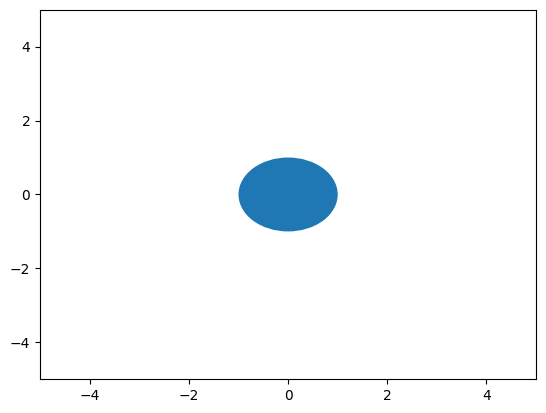

In [158]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


ax = plt.gca()

c = Circle(xy=(0,0), radius=1)
ax.add_patch(c)

print(c.contains_point((0,0)))

ax.set_xlim([-5,5])
ax.set_ylim([-5,5])

print(c.contains_point((0,0)))

In [201]:
score = []

for i in range(1, 11):

    gm = GaussianMixture(n_components=i)
    gm.fit(data)


    # (patch, data index)
    patches, coverage = get_patches(gm, 0.95)
    total_coverage = np.sum(coverage, axis=0) != 0
    num_covered = np.sum(total_coverage)

    valid_patches = coverage.sum(axis=1) >= data.shape[0]/10
    valid_covered = (coverage[valid_patches].sum(axis=0) != 0).sum()
    overlapped = (coverage.sum(axis=0) > 1).sum()

    score.append((valid_covered - overlapped)/data.shape[0])

print(score)

[np.float64(0.9886666666666667), np.float64(0.8946666666666667), np.float64(0.32133333333333336), np.float64(0.228), np.float64(0.176), np.float64(0.08066666666666666), np.float64(0.2806666666666667), np.float64(0.021333333333333333), np.float64(0.028666666666666667), np.float64(0.028)]
